### Objective

The objective is to extract a set of prosodic correlates (i.e. suprasegmental speech parameters) and cepstral features from speech recordings. Then, an emotion recognition system is constructed to recognize happy versus sad emotional speech (a quite easy two class problem) using a simple supervised classifier training and testing structure.

The original speech data is a set of simulated emotional speech (i.e. acted) from ten speakers speaking five different pre-segmented sentences of roughly 2-3 seconds in two different emotional states (happy and sad) totaling 100 samples.
Basic prosodic features (i.e. distribution parameters derived from the prosodic correlates) are extracted using a simple voiced/unvoiced analysis of speech, pitch tracker, and energy analysis. Another set of Mel-Frequency Cepstral Coefficients (MFCC) features are also calculated for comparison. 

Support Vector Machine (SVM) classifiers are trained. A random subset of 1/2 of the available speech data (i.e. half of the persons) is used to train the emotion recognition system, first using a set of simple prosodic parameter features and a then a classical set of MFCC derived features. The rest of the data (the other half of the persons) is then used to evaluate the performances of the trained recognition systems.


<!--### Task 0.1. Load Data
Load the ‘speech_sample’ from the provided dataset containing a raw speech waveform and do the following (Note, the sampling rate (fs) of the sample speech signal is 48 kHz):-->

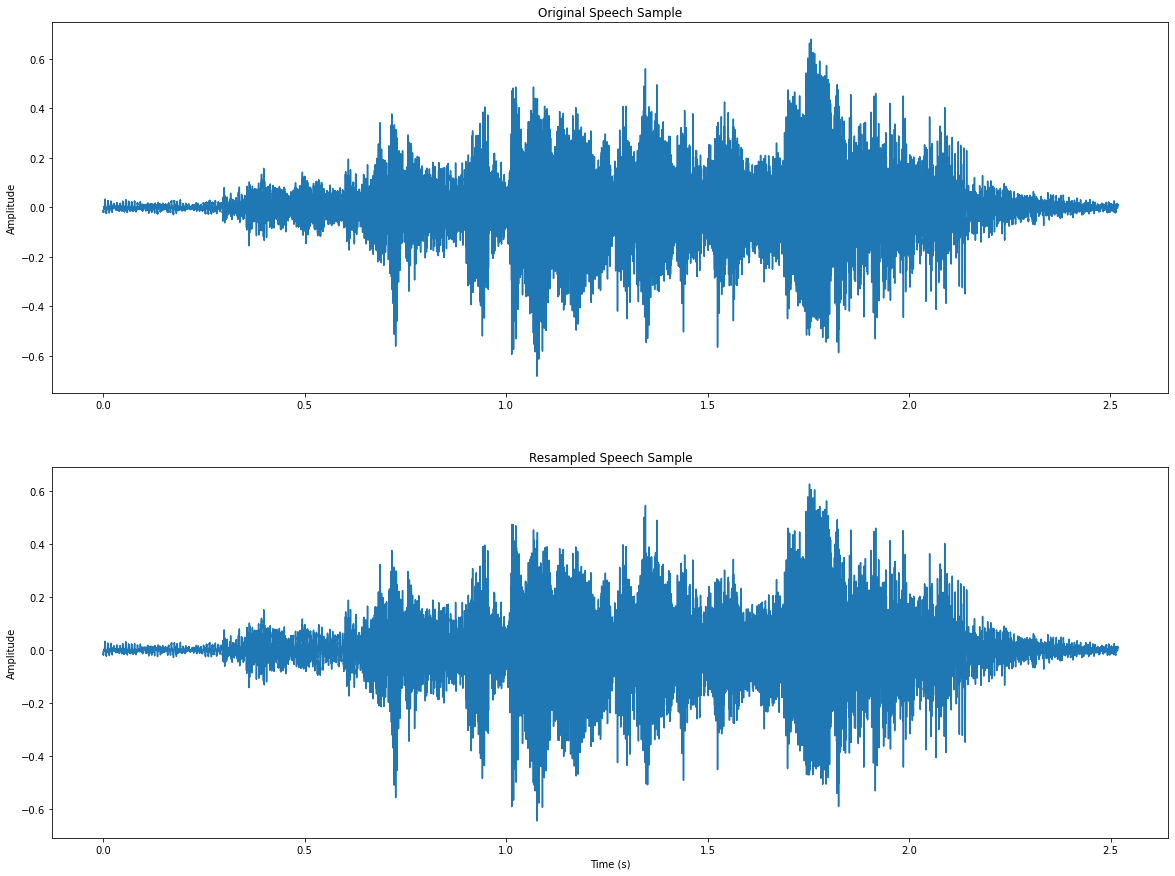

In [126]:
import numpy as np
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt

# Load the 'speech_sample'
exercise_data = sio.loadmat('lab2_data.mat')
speech_sample = exercise_data['speech_sample'].reshape(-1)

# Source sampling frequency
fs_source = 48000

# Target sampling frequency
fs_down = 11025

# 3. Downsample the speech sample
resample_size = int((len(speech_sample)/fs_source)*fs_down)
speech_resampled = signal.resample(speech_sample,resample_size)




#Time vector for original speech sample
stop = len(speech_sample)/fs_source 
time_vector = np.linspace(0, stop, num=len(speech_sample))

#Time vector for resampled speech sample
stop2 = len(speech_resampled)/fs_down 
time_vector2 = np.linspace(0, stop2, num=len(speech_resampled))

# Visualize the speech signals in the time domain.
fig, ax = plt.subplots(2, 1, figsize=(20, 15))

# Original Speech Sample
ax[0].plot(time_vector, speech_sample)
ax[0].title.set_text('Original Speech Sample')
#ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

# Resampled Speech Sample
ax[1].plot(time_vector2, speech_resampled)
ax[1].title.set_text('Resampled Speech Sample')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Amplitude')

plt.show()


## Feature Extraction

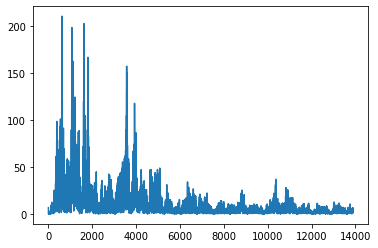

In [57]:
from scipy.fftpack import fft
plt.plot(abs(fft(speech_resampled))[:int(len(speech_resampled)/2)])

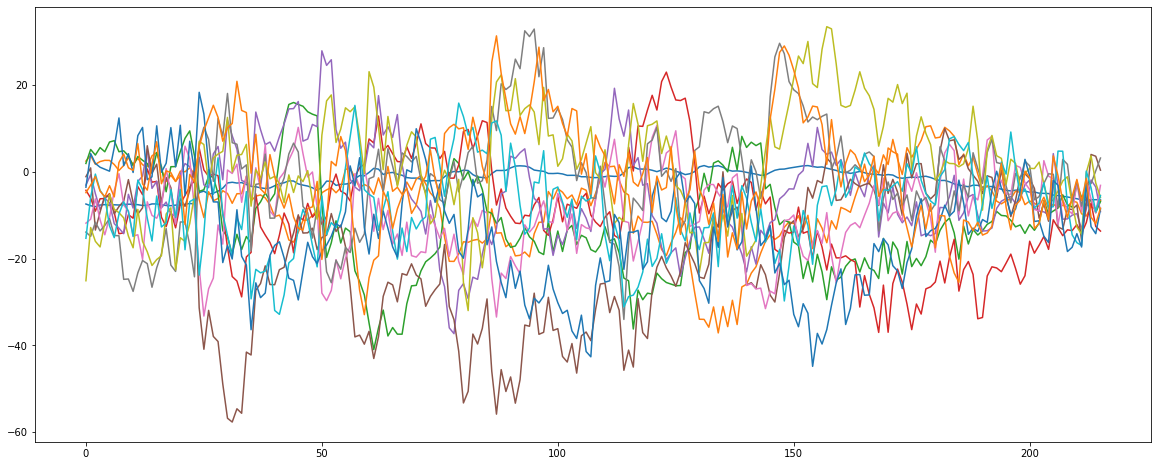

Mean of each contour:
 [-2.1703191077515376, -7.575367884545424, -11.543002489146511, -9.236878775755716, -5.064750504977879, -19.071636105147903, -9.45254527440595, -0.9562420534132525, 1.6041838695561568, -7.878679083731293, -13.984301758889458, -0.684742076921787]


In [150]:
from scipy.signal import lfilter
from python_speech_features import mfcc

# Apply the filter on the signal
pre_emphasized_sample = np.append(speech_resampled[0], speech_resampled[1:] - 0.98 * speech_resampled[:-1])

# 2. Extract the mfcc coefficients
frame_len = int(2 ** np.floor(np.log2(0.03 * fs_down)))
mfcc_contour = mfcc(pre_emphasized_sample, 
                   fs_down, 
                   winlen = frame_len / fs_down, 
                   winstep = frame_len / (2 * fs_down), 
                   numcep = 12, 
                   preemph = 0)

# Reshape the mfcc_contour matrix - change cols to rows and vice versa
mfcc = {}
for i in range(len(mfcc_contour[0])):
    mfcc[i] = []
for i in mfcc_contour:
    for index, j in enumerate(i):
        mfcc[index].append(j)

# Visualize the 12 mfcc contours
plt.figure(figsize=(20,8))
for i in mfcc.keys():
    plt.plot(mfcc[i])
plt.show()

# Calculate the mean for each contour.
means = [np.mean(i[1]) for i in mfcc.items()]
print(f'Mean of each contour:\n {means}')

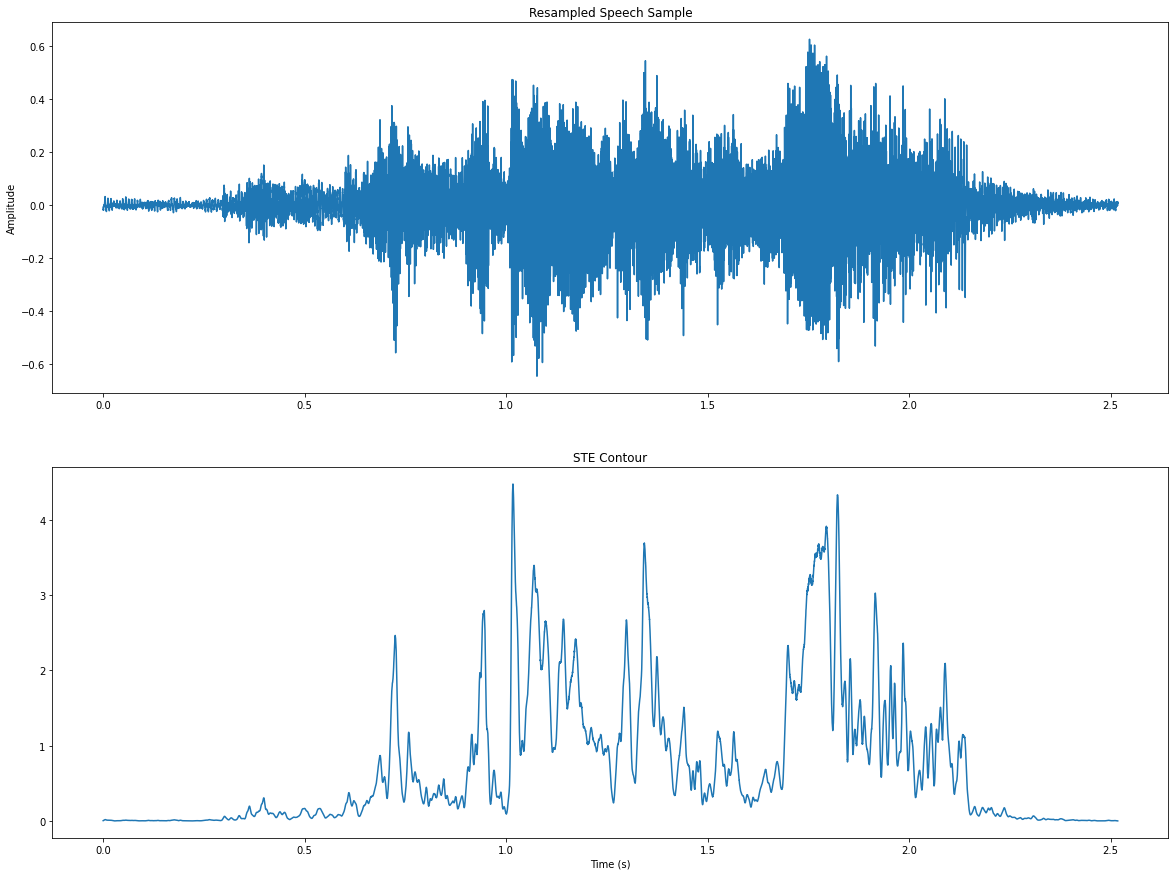

Features from STE:
Mean: 0.7478401748173372
STD: 0.9053435629299118
10th-Percentile: 0.007381280991260072
90th-Percentile: 2.0804731247437718
Kurtosis: 1.9384292132739516


In [127]:
from scipy.stats import kurtosis

# Calculate the hamming window length, which is the number of frames within 0.01s
#print(len(speech_resampled))
#print(time_vector2[-1])
hamming_length = int((0.01 / time_vector2[-1]) * len(speech_resampled))

# Define the hamming window
hamming_window = signal.hamming(hamming_length)

# Calculate the short time energy (STE) contour by convolving the hamming window and the squared signal
squared_signal = [i**2 for i in speech_resampled]
ste = signal.convolve(squared_signal, hamming_window)


# Clip half a window of frames from both the beginning and end of the STE contour
ste = ste[int(hamming_length / 2):-int(hamming_length / 2) +1]



# Visualize speech_resampled and the STE contour
fig, ax = plt.subplots(2, 1, figsize=(20, 15))


# Resampled Speech Sample
ax[0].plot(time_vector2, speech_resampled)
ax[0].title.set_text('Resampled Speech Sample')
#ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

# STE Contour
ax[1].plot(time_vector2, ste)
ax[1].title.set_text('STE Contour')
ax[1].set_xlabel('Time (s)')

plt.show()

# Calculate the 5 distribution parameter features the of STE contour
print('Features from STE:')
print(f'Mean: {np.mean(ste)}')
print(f'STD: {np.std(ste)}')
print(f'10th-Percentile: {np.percentile(ste, 10)}')
print(f'90th-Percentile: {np.percentile(ste, 90)}')
print(f'Kurtosis: {kurtosis(ste)}')

In [10]:
import warnings
warnings.filterwarnings("ignore")

F:\University of Oulu\Affective Computing\exercise2\f0_lib.py:171: RuntimeWarning: divide by zero encountered in true_divide
  ran = ra / rw;
F:\University of Oulu\Affective Computing\exercise2\f0_lib.py:171: RuntimeWarning: invalid value encountered in true_divide
  ran = ra / rw;


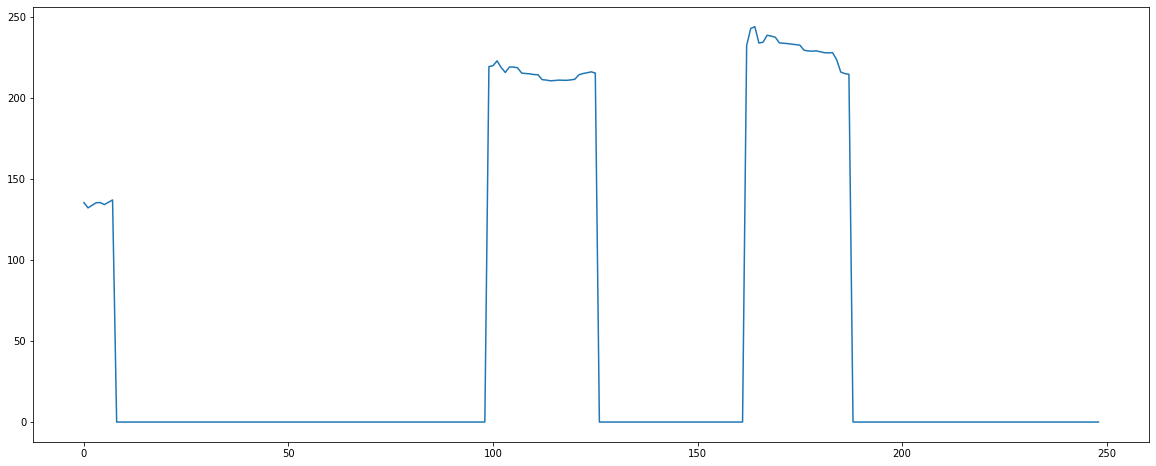

Features from F0:
Mean: 51.76644479473558
STD: 92.16685962797015
10th-Percentile: 0.0
90th-Percentile: 219.60425158045447
Kurtosis: -0.32758005245094113


In [99]:
import numpy as np
import scipy.io as sio
from scipy import signal
import scipy
from f0_lib import get_f0

# Extract the F0 contour
f0,strength,T_ind,wlfag = get_f0(speech_resampled, fs_down)

# Visualize the F0 contour
plt.figure(figsize=(20,8))
plt.plot(f0)
plt.show()

# Calculate these distribution parameter features
print('Features from F0:')
print(f'Mean: {np.mean(f0)}')
print(f'STD: {np.std(f0)}')
print(f'10th-Percentile: {np.percentile(f0, 10)}')
print(f'90th-Percentile: {np.percentile(f0, 90)}')
print(f'Kurtosis: {kurtosis(f0)}')

In [116]:
# Segmenting the voiced speech segements.
voiced_inds = np.where(f0 > 0)[0]
diff = voiced_inds[1:] - voiced_inds[: -1]
voiced_to_unvoiced_inds = np.where(diff > 1)[0]
voiced_seg_n = len(voiced_to_unvoiced_inds) + 1
voiced_seg_lengths = np.zeros(voiced_seg_n)
tmp = voiced_inds[0]

for i in range(voiced_seg_n - 1):
    voiced_seg_lengths[i] = voiced_inds[voiced_to_unvoiced_inds[i]] - tmp + 1
    tmp = voiced_inds[voiced_to_unvoiced_inds[i] + 1]
    
voiced_seg_lengths[-1] = voiced_inds[-1] - tmp + 1


# Segmenting unvoiced speech segements.
unvoiced_inds = np.where(f0 == 0)[0]
diff = unvoiced_inds[1:] - unvoiced_inds[: -1]
unvoiced_to_voiced_inds = np.where(diff > 1)[0]
unvoiced_seg_n = len(unvoiced_to_voiced_inds) + 1
unvoiced_seg_lengths = np.zeros(unvoiced_seg_n)
tmp = unvoiced_inds[0]

for i in range(unvoiced_seg_n - 1):
    unvoiced_seg_lengths[i] = unvoiced_inds[unvoiced_to_voiced_inds[i]] - tmp + 1
    tmp = unvoiced_inds[unvoiced_to_voiced_inds[i] + 1]
    
unvoiced_seg_lengths[-1] = unvoiced_inds[-1] - tmp + 1



# Calculate the means and SDs of both Voiced and Unvoiced segment lengths
print('Features from F0:')
print(f'Mean of Voiced: {np.mean(voiced_seg_lengths)}')
print(f'Mean of Unvoiced: {np.mean(unvoiced_seg_lengths)}')
print(f'STD of Voiced: {np.std(voiced_seg_lengths)}')
print(f'STD of Unvoiced: {np.std(unvoiced_seg_lengths)}')
# Calculate the voicing ratio.
print(f'Voicing Ratio: {len(np.where(f0 > 0)[0]) / len(f0)}')

Features from F0:
Mean of Voiced: 20.333333333333332
Mean of Unvoiced: 62.666666666666664
STD of Voiced: 8.73053390247253
STD of Unvoiced: 22.48456260538674
Voicing Ratio: 0.24497991967871485



## Speech Emotion Classification

In this part, the [`sklearn.svm`](http://scikit-learn.org/stable/modules/svm.html) library is used to perform the speech signal classification. The **‘training_data_proso’** and **‘training_data_mfcc’** matrices contain the calculated prosodic features for the training set (9 features in each row representing a speech sample) and MFCC derived features (12 features) respectively. The **‘training_class’** group vector contains the class of samples: 1 = happy, 2 = sad; corresponding to the rows of the training data matrices.

<!---speech_sample
testing_class
testing_data_mfcc
testing_data_proso
testing_personID
training_class
training_data_mfcc
training_data_proso
training_personID
### Task 2.1. Preparing your data
Dictionaries of the data are listed below:
* speech_sample
* testing_class
* testing_data_mfcc
* testing_data_proso
* testing_personID
* training_class
* training_data_mfcc
* training_data_proso
* training_personID
Use [`scipy.io.loadmat()`] to read the dataset.-->

### Train the SVM classifiers

In [120]:
from sklearn import svm

# Load the data
exercise_data = sio.loadmat('lab2_data.mat')
training_data_proso = exercise_data['training_data_proso']
training_data_mfcc = exercise_data['training_data_mfcc']
training_class = exercise_data['training_class'].reshape(-1)




# Train a classifier using the prodosic data
clf1 = svm.SVC(kernel='poly', degree=3)
clf1.fit(training_data_proso, training_class)


# Train a classifer using the mfcc data
clf2 = svm.SVC(kernel='poly', degree=3)
clf2.fit(training_data_mfcc, training_class)

SVC(kernel='poly')

### Testing the classifiers


In [122]:
from sklearn.metrics import accuracy_score
# Load testing data
testing_data_mfcc = exercise_data['testing_data_mfcc']
testing_data_proso = exercise_data['testing_data_proso']
testing_class = exercise_data['testing_class'].reshape(-1)

# Calculate the average classification performances for the training data
y_train_proso = clf1.predict(training_data_proso)
y_train_mfcc = clf2.predict(training_data_mfcc)

# Calculate the average classification performance for the testing data
y_test_proso = clf1.predict(testing_data_proso)
y_test_mfcc = clf2.predict(testing_data_mfcc)


# Print the four accuracies.
print(f"Prosody - Training Data Accuracy: {accuracy_score(training_class, y_train_proso)}")
print(f"Prosody - Testing Data Accuracy: {accuracy_score(testing_class, y_test_proso)}")
print(f"MFCC - Training Data Accuracy: {accuracy_score(training_class, y_train_mfcc)}")
print(f"MFCC - Testing Data Accuracy: {accuracy_score(testing_class, y_test_mfcc)}")

Prosody - Training Data Accuracy: 0.84
Prosody - Testing Data Accuracy: 0.62
MFCC - Training Data Accuracy: 0.96
MFCC - Testing Data Accuracy: 0.84


Prosody - Training Data Accuracy:
 [[17  8]
 [ 0 25]]


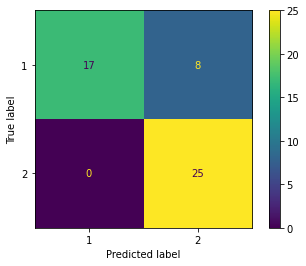

Prosody - Testing Data Accuracy:
 [[ 9 16]
 [ 3 22]]


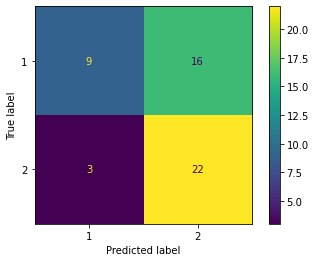

MFCC - Training Data Accuracy:
 [[23  2]
 [ 0 25]]


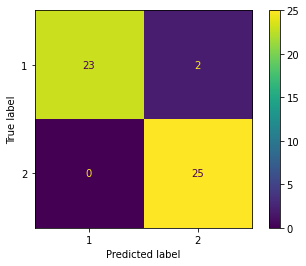

MFCC - Testing Data Accuracy:
 [[22  3]
 [ 5 20]]


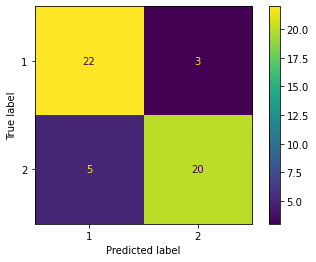

In [125]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print(f"Prosody - Training Data Accuracy:\n {confusion_matrix(training_class, y_train_proso)}")
# A better view of the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(training_class, y_train_proso), display_labels=clf1.classes_)
disp.plot()
plt.show()

print(f"Prosody - Testing Data Accuracy:\n {confusion_matrix(testing_class, y_test_proso)}")
# A better view of the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(testing_class, y_test_proso), display_labels=clf1.classes_)
disp.plot()
plt.show()

print(f"MFCC - Training Data Accuracy:\n {confusion_matrix(training_class, y_train_mfcc)}")
# A better view of the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(training_class, y_train_mfcc), display_labels=clf2.classes_)
disp.plot()
plt.show()

print(f"MFCC - Testing Data Accuracy:\n {confusion_matrix(training_class, y_test_mfcc)}")
# A better view of the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(training_class, y_test_mfcc), display_labels=clf2.classes_)
disp.plot()
plt.show()

Looking at the testing and training data accuracies of the model trained on prosody features - It seems to have trouble predicting a "happy" face correctly. There could be different reasons for this, one being the similarities of these features in both "happy" and "sad" faces.

The model trained on MFCC features seemed to perform decently. A larger testing dataset would be required to determine if the margin for error is similar for classifying both "happy" and "sad" faces - From the given testing dataset the missclassification for "sad" faces seem to occur nearly at double the rate of missclassifying "happy" faces.